# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

# Non shared resources
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['ac', 'air_panas', 'bau', 'general', 'kebersihan', 'linen', 'service', 'sunrise_meal', 'tv', 'wifi']
aspect_mapping = {'ac': 0, 'air_panas': 1, 'bau': 2, 'general': 3, 'kebersihan': 4, 'linen': 5, 'service': 6, 'sunrise_meal': 7, 'tv': 8, 'wifi': 9}
label_mapping = {"neg": 0, "neut": 1, 'neg_pos': 1, 'pos': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/hoasa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/hoasa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/hoasa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,review,ac,air_panas,bau,general,kebersihan,linen,service,sunrise_meal,tv,wifi
0,kebersihan kurang...,neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
1,"sangat mengecewakan... hotel bad image, kebers...",neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
2,Tempat nyaman bersih tapi tv terlalu tinggi ti...,neut,neut,neut,neut,pos,neut,neut,neut,neg,neut
3,"semuanya bagus sesuai profile,dan harga promo ...",neut,neg,neut,pos,neut,neut,neut,neut,neut,neut
4,"Tempat tidur sangat keras, bantal besar dan ke...",neg,neg,neut,neut,neut,neg,neut,neut,neut,neut


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [8]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['review'].values
y_train = train_data[train_labels].values
X_val = val_data['review'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2283,) (2283, 10)
(571,) (571, 10)


# BUILD DATASET & DATALOADERS

In [9]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [10]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [11]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [12]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [13]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [14]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 50

In [15]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [16]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }


In [17]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            aspect_list,
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model-{percentage}')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model-{percentage}')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [18]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def random_sampling(current_train_size, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    start_time = time.time()
    
    nearest_cp = 0
    arrived_at_cp = False
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    num_of_candidates = math.ceil(0.1 * len(remaining_indices))

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        num_of_candidates = n_samples
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        num_of_candidates = max(n_samples, num_of_candidates)
    else:
        num_of_candidates = nearest_cp - current_train_size
        arrived_at_cp = True

    random_indices = random.sample(range(len(X_pool)), num_of_candidates)

    if arrived_at_cp:
        temp = train_indices.copy()
        temp.extend([remaining_indices[i] for i in random_indices])
            
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'ac': [y_train[i][0] for i in temp],
            'air_panas': [y_train[i][1] for i in temp],
            'bau': [y_train[i][2] for i in temp],
            'general': [y_train[i][3] for i in temp],
            'kebersihan': [y_train[i][4] for i in temp],
            'linen': [y_train[i][5] for i in temp],
            'service': [y_train[i][6] for i in temp],
            'sunrise_meal': [y_train[i][7] for i in temp],
            'tv': [y_train[i][8] for i in temp],
            'wifi': [y_train[i][9] for i in temp],
        })

        acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time() 
    duration = end_time - start_time

    sampling_dur.append(duration)
    for i in random_indices:
        new_samples.append(remaining_indices[i])
        
    print("Nearest checkpoint:", nearest_cp)
    print("Acquired samples:", len(random_indices))
    print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [20]:
def active_learning(seed, i, init_size):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    filename = f'hoasa-random-init-{init_size}'

    set_seed(seed)
    
    print("===============================================")
    print("Init Size {}".format(init_size))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed,
            filename
        )
        notebook_launcher(train_model, args, num_processes=2)
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        random_sampling(
            current_train_size, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i,
            filename
        )
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed,
        filename
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    aspect_accuracies, aspect_f1_micros, aspect_f1_macros = list(aspect_accuracies), list(aspect_f1_micros), list(aspect_f1_macros)
    sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros = list(sentiment_accuracies), list(sentiment_f1_micros), list(sentiment_f1_macros)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

Init Size 1
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7629, Accuracy: 0.4733, F1 Micro: 0.5873, F1 Macro: 0.491
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.7254, Accuracy: 0.5719, F1 Micro: 0.6993, F1 Macro: 0.6035
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.6779, Accuracy: 0.6304, F1 Micro: 0.7608, F1 Macro: 0.6848
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.616, Accuracy: 0.6764, F1 Micro: 0.8005, F1 Macro: 0.756
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5873, Accuracy: 0.7193, F1 Micro: 0.8328, F1 Macro: 0.8117
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.5466, Accuracy: 0.7545, F1 Micro: 0.8574, F1 Macro: 0.8462
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.5374, Accuracy: 0.7812, F1 Micro: 0.8753, F1 Macro: 0.868
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4948, Accuracy: 0.7958, F1 Micro: 0.8848, F1 Macro: 0.8769
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7093, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6098, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5463, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4848, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4943, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4027, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3762, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4164, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6338, Accuracy: 0.8009, F1 Micro: 0.8894, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4775, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4435, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4282, Accuracy: 0.8016, F1 Micro: 0.8898, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4132, Accuracy: 0.8174, F1 Micro: 0.8967, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3796, Accuracy: 0.83, F1 Micro: 0.9036, F1 Macro: 0.8987
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.325, Accuracy: 0.8585, F1 Micro: 0.9171, F1 Macro: 0.9106
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3112, Accuracy: 0.8762, F1 Micro: 0.9271, F1 Macro: 0.9215
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5122, Accuracy: 0.7381, F1 Micro: 0.7381, F1 Macro: 0.4247
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4027, Accuracy: 0.7381, F1 Micro: 0.7381, F1 Macro: 0.4247
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3287, Accuracy: 0.772, F1 Micro: 0.772, F1 Macro: 0.6169
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2672, Accuracy: 0.8005, F1 Micro: 0.8005, F1 Macro: 0.7251
Epoch 5/10, Train Loss: 0.2281, Accuracy: 0.7924, F1 Micro: 0.7924, F1 Macro: 0.6967
Epoch 6/10, Train Loss: 0.2493, Accuracy: 0.7856, F1 Micro: 0.7856, F1 Macro: 0.7199
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2072, Accuracy: 0.8019, F1 Micro: 0.8019, F1 Macro: 0.7254
Epoch 8/10, Train Loss: 0.1328, Accuracy: 0.7951, F1 Micro: 0.7951, F1 Macro: 0.7166
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1372, Accuracy: 0.806, F1 Micro: 0.806, F1 Macro: 0.7165
Epoch 10/10, Train Loss: 0.0995, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5631, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4467, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4231, Accuracy: 0.8186, F1 Micro: 0.8983, F1 Macro: 0.8939
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3634, Accuracy: 0.8646, F1 Micro: 0.9206, F1 Macro: 0.9148
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3179, Accuracy: 0.8832, F1 Micro: 0.9307, F1 Macro: 0.9252
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2722, Accuracy: 0.9, F1 Micro: 0.9401, F1 Macro: 0.9349
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2244, Accuracy: 0.9193, F1 Micro: 0.9509, F1 Macro: 0.9467
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2058, Accuracy: 0.9236, F1 Micro: 0.9537, F1 Macro: 0.9499
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5153, Accuracy: 0.7256, F1 Micro: 0.7256, F1 Macro: 0.4205
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3186, Accuracy: 0.7802, F1 Micro: 0.7802, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2726, Accuracy: 0.8212, F1 Micro: 0.8212, F1 Macro: 0.7411
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.232, Accuracy: 0.8212, F1 Micro: 0.8212, F1 Macro: 0.7329
Epoch 5/10, Train Loss: 0.1983, Accuracy: 0.7666, F1 Micro: 0.7666, F1 Macro: 0.5631
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1991, Accuracy: 0.8328, F1 Micro: 0.8328, F1 Macro: 0.7744
Epoch 7/10, Train Loss: 0.1288, Accuracy: 0.8297, F1 Micro: 0.8297, F1 Macro: 0.7473
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1423, Accuracy: 0.8433, F1 Micro: 0.8433, F1 Macro: 0.772
Epoch 9/10, Train Loss: 0.0855, Accuracy: 0.8328, F1 Micro: 0.8328, F1 Macro: 0.755
Epoch 10/10, Train Loss: 0.0955, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.546, Accuracy: 0.8017, F1 Micro: 0.8899, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.431, Accuracy: 0.8101, F1 Micro: 0.8935, F1 Macro: 0.8879
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3924, Accuracy: 0.8601, F1 Micro: 0.9188, F1 Macro: 0.9135
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3152, Accuracy: 0.8837, F1 Micro: 0.9315, F1 Macro: 0.9271
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2664, Accuracy: 0.9167, F1 Micro: 0.9497, F1 Macro: 0.9455
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2184, Accuracy: 0.9264, F1 Micro: 0.9556, F1 Macro: 0.953
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1976, Accuracy: 0.9335, F1 Micro: 0.9595, F1 Macro: 0.957
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1649, Accuracy: 0.9398, F1 Micro: 0.9632, F1 Macro: 0.9611
Epoch 9/10, Train Loss: 0.1481, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4241, Accuracy: 0.7914, F1 Micro: 0.7914, F1 Macro: 0.5877
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3081, Accuracy: 0.8409, F1 Micro: 0.8409, F1 Macro: 0.7313
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2024, Accuracy: 0.8546, F1 Micro: 0.8546, F1 Macro: 0.7861
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1416, Accuracy: 0.8641, F1 Micro: 0.8641, F1 Macro: 0.7938
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.8704, F1 Micro: 0.8704, F1 Macro: 0.7956
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0861, Accuracy: 0.8767, F1 Micro: 0.8767, F1 Macro: 0.8214
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0892, Accuracy: 0.882, F1 Micro: 0.882, F1 Macro: 0.8172
Epoch 8/10, Train Loss: 0.0877, Accuracy: 0.8809, F1 Micro: 0.8809, F1 Macro: 0.8152
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0363, Accuracy: 0.882, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5223, Accuracy: 0.8071, F1 Micro: 0.8916, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4161, Accuracy: 0.841, F1 Micro: 0.9084, F1 Macro: 0.9019
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3435, Accuracy: 0.8858, F1 Micro: 0.9321, F1 Macro: 0.9256
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2798, Accuracy: 0.9135, F1 Micro: 0.9479, F1 Macro: 0.944
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2168, Accuracy: 0.9326, F1 Micro: 0.959, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1867, Accuracy: 0.9375, F1 Micro: 0.962, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1611, Accuracy: 0.9401, F1 Micro: 0.9635, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1413, Accuracy: 0.9443, F1 Micro: 0.9658, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3968, Accuracy: 0.7578, F1 Micro: 0.7578, F1 Macro: 0.5311
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2291, Accuracy: 0.8564, F1 Micro: 0.8564, F1 Macro: 0.7967
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1535, Accuracy: 0.8604, F1 Micro: 0.8604, F1 Macro: 0.8005
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.16, Accuracy: 0.8633, F1 Micro: 0.8633, F1 Macro: 0.8037
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1154, Accuracy: 0.8691, F1 Micro: 0.8691, F1 Macro: 0.811
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.8799, F1 Micro: 0.8799, F1 Macro: 0.8314
Epoch 7/10, Train Loss: 0.0426, Accuracy: 0.874, F1 Micro: 0.874, F1 Macro: 0.8232
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0331, Accuracy: 0.8877, F1 Micro: 0.8877, F1 Macro: 0.8464
Epoch 9/10, Train Loss: 0.0451, Accuracy: 0.8799, F1 Micro: 0.8799, F1 Macro: 0.8319
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5159, Accuracy: 0.8028, F1 Micro: 0.8904, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4187, Accuracy: 0.8599, F1 Micro: 0.9182, F1 Macro: 0.9116
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3151, Accuracy: 0.9003, F1 Micro: 0.9408, F1 Macro: 0.9369
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2495, Accuracy: 0.9302, F1 Micro: 0.9575, F1 Macro: 0.9544
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1972, Accuracy: 0.9384, F1 Micro: 0.9625, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.167, Accuracy: 0.9469, F1 Micro: 0.9674, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1469, Accuracy: 0.9479, F1 Micro: 0.9681, F1 Macro: 0.9657
Epoch 8/10, Train Loss: 0.1257, Accuracy: 0.9474, F1 Micro: 0.9678, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1131, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4107, Accuracy: 0.7978, F1 Micro: 0.7978, F1 Macro: 0.759
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2464, Accuracy: 0.8506, F1 Micro: 0.8506, F1 Macro: 0.7685
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1907, Accuracy: 0.8665, F1 Micro: 0.8665, F1 Macro: 0.799
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1479, Accuracy: 0.9044, F1 Micro: 0.9044, F1 Macro: 0.8678
Epoch 5/10, Train Loss: 0.0964, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8643
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0793, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8683
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.066, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.879
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0511, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8753
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.871
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5117, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3972, Accuracy: 0.8837, F1 Micro: 0.9311, F1 Macro: 0.926
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2844, Accuracy: 0.9233, F1 Micro: 0.9535, F1 Macro: 0.9504
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2184, Accuracy: 0.9354, F1 Micro: 0.9608, F1 Macro: 0.9587
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1846, Accuracy: 0.9439, F1 Micro: 0.9656, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1569, Accuracy: 0.9514, F1 Micro: 0.9701, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1365, Accuracy: 0.9519, F1 Micro: 0.9705, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1146, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9709
Epoch 9/10, Train Loss: 0.0987, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4041, Accuracy: 0.847, F1 Micro: 0.847, F1 Macro: 0.7892
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2008, Accuracy: 0.8577, F1 Micro: 0.8577, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1677, Accuracy: 0.8829, F1 Micro: 0.8829, F1 Macro: 0.8361
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1115, Accuracy: 0.8935, F1 Micro: 0.8935, F1 Macro: 0.8533
Epoch 5/10, Train Loss: 0.075, Accuracy: 0.8925, F1 Micro: 0.8925, F1 Macro: 0.8509
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0713, Accuracy: 0.8955, F1 Micro: 0.8955, F1 Macro: 0.8535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0544, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8699
Epoch 8/10, Train Loss: 0.0332, Accuracy: 0.8935, F1 Micro: 0.8935, F1 Macro: 0.8507
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8733
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5043, Accuracy: 0.8042, F1 Micro: 0.891, F1 Macro: 0.8865
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3772, Accuracy: 0.8901, F1 Micro: 0.9344, F1 Macro: 0.9284
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2788, Accuracy: 0.9293, F1 Micro: 0.9572, F1 Macro: 0.955
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2037, Accuracy: 0.9382, F1 Micro: 0.9623, F1 Macro: 0.9601
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1811, Accuracy: 0.946, F1 Micro: 0.9669, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1457, Accuracy: 0.9483, F1 Micro: 0.9683, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.126, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1065, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9725
Epoch 9/10, Train Loss: 0.0926, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3734, Accuracy: 0.8527, F1 Micro: 0.8527, F1 Macro: 0.8001
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2492, Accuracy: 0.8621, F1 Micro: 0.8621, F1 Macro: 0.8175
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1708, Accuracy: 0.8724, F1 Micro: 0.8724, F1 Macro: 0.8318
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1302, Accuracy: 0.8874, F1 Micro: 0.8874, F1 Macro: 0.854
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0905, Accuracy: 0.8949, F1 Micro: 0.8949, F1 Macro: 0.8621
Epoch 6/10, Train Loss: 0.0675, Accuracy: 0.8921, F1 Micro: 0.8921, F1 Macro: 0.8565
Epoch 7/10, Train Loss: 0.0527, Accuracy: 0.8865, F1 Micro: 0.8865, F1 Macro: 0.8479
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0428, Accuracy: 0.8959, F1 Micro: 0.8959, F1 Macro: 0.8667
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0303, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.8674
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.488, Accuracy: 0.8148, F1 Micro: 0.8959, F1 Macro: 0.8918
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3487, Accuracy: 0.8965, F1 Micro: 0.9385, F1 Macro: 0.934
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2499, Accuracy: 0.9276, F1 Micro: 0.9562, F1 Macro: 0.9533
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.193, Accuracy: 0.9448, F1 Micro: 0.9662, F1 Macro: 0.9641
Epoch 5/10, Train Loss: 0.1617, Accuracy: 0.9446, F1 Micro: 0.9661, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1393, Accuracy: 0.954, F1 Micro: 0.9717, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1102, Accuracy: 0.9549, F1 Micro: 0.9721, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0974, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0836, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3935, Accuracy: 0.8451, F1 Micro: 0.8451, F1 Macro: 0.7829
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.199, Accuracy: 0.8685, F1 Micro: 0.8685, F1 Macro: 0.8304
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1627, Accuracy: 0.8817, F1 Micro: 0.8817, F1 Macro: 0.8507
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1056, Accuracy: 0.8892, F1 Micro: 0.8892, F1 Macro: 0.8522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0922, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8722
Epoch 6/10, Train Loss: 0.0662, Accuracy: 0.8911, F1 Micro: 0.8911, F1 Macro: 0.8532
Epoch 7/10, Train Loss: 0.0444, Accuracy: 0.8977, F1 Micro: 0.8977, F1 Macro: 0.8643
Epoch 8/10, Train Loss: 0.0475, Accuracy: 0.8901, F1 Micro: 0.8901, F1 Macro: 0.854
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.041, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8744
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4831, Accuracy: 0.8115, F1 Micro: 0.8943, F1 Macro: 0.889
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3392, Accuracy: 0.905, F1 Micro: 0.9432, F1 Macro: 0.9394
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2403, Accuracy: 0.9368, F1 Micro: 0.9615, F1 Macro: 0.9593
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.187, Accuracy: 0.9438, F1 Micro: 0.9656, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1651, Accuracy: 0.9481, F1 Micro: 0.9682, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.13, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1139, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.093, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 9/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.374, Accuracy: 0.8548, F1 Micro: 0.8548, F1 Macro: 0.814
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2044, Accuracy: 0.8666, F1 Micro: 0.8666, F1 Macro: 0.8293
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1549, Accuracy: 0.873, F1 Micro: 0.873, F1 Macro: 0.8279
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1129, Accuracy: 0.8956, F1 Micro: 0.8956, F1 Macro: 0.8668
Epoch 5/10, Train Loss: 0.0854, Accuracy: 0.8702, F1 Micro: 0.8702, F1 Macro: 0.8208
Epoch 6/10, Train Loss: 0.0668, Accuracy: 0.8811, F1 Micro: 0.8811, F1 Macro: 0.8452
Epoch 7/10, Train Loss: 0.0566, Accuracy: 0.8893, F1 Micro: 0.8893, F1 Macro: 0.854
Epoch 8/10, Train Loss: 0.0466, Accuracy: 0.8757, F1 Micro: 0.8757, F1 Macro: 0.8338
Epoch 9/10, Train Loss: 0.026, Accuracy: 0.8902, F1 Micro: 0.8902, F1 Macro: 0.854
Epoch 10/10, Train Loss: 0.0382, Accuracy: 0.8857, F1 Micro: 0.8857, F1 Macro: 0.8474

Sentiment analysis accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4936, Accuracy: 0.8231, F1 Micro: 0.8993, F1 Macro: 0.8921
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3457, Accuracy: 0.9113, F1 Micro: 0.9462, F1 Macro: 0.9421
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2377, Accuracy: 0.9375, F1 Micro: 0.962, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1951, Accuracy: 0.9429, F1 Micro: 0.9652, F1 Macro: 0.9631
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1533, Accuracy: 0.9517, F1 Micro: 0.9704, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1364, Accuracy: 0.9576, F1 Micro: 0.9739, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.116, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0975, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9734
Epoch 9/10, Train Loss: 0.0842, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3492, Accuracy: 0.8474, F1 Micro: 0.8474, F1 Macro: 0.7744
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2022, Accuracy: 0.8758, F1 Micro: 0.8758, F1 Macro: 0.8317
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1561, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8735
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1226, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0811, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.8833
Epoch 6/10, Train Loss: 0.0486, Accuracy: 0.8948, F1 Micro: 0.8948, F1 Macro: 0.8567
Epoch 7/10, Train Loss: 0.0474, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.8776
Epoch 8/10, Train Loss: 0.0395, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8797
Epoch 9/10, Train Loss: 0.0274, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8732
Epoch 10/10, Train Loss: 0.0348, Accuracy: 0.9081, F1 Micro: 0.9081, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4894, Accuracy: 0.8247, F1 Micro: 0.8989, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3306, Accuracy: 0.9144, F1 Micro: 0.9485, F1 Macro: 0.9452
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.228, Accuracy: 0.9411, F1 Micro: 0.9641, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1762, Accuracy: 0.9491, F1 Micro: 0.9688, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1458, Accuracy: 0.9519, F1 Micro: 0.9705, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1285, Accuracy: 0.9524, F1 Micro: 0.9708, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1066, Accuracy: 0.9575, F1 Micro: 0.9736, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0901, Accuracy: 0.9576, F1 Micro: 0.9739, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3695, Accuracy: 0.848, F1 Micro: 0.848, F1 Macro: 0.7828
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2058, Accuracy: 0.8744, F1 Micro: 0.8744, F1 Macro: 0.8276
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1642, Accuracy: 0.8754, F1 Micro: 0.8754, F1 Macro: 0.8253
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0995, Accuracy: 0.899, F1 Micro: 0.899, F1 Macro: 0.8631
Epoch 5/10, Train Loss: 0.0811, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.8693
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0558, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.866
Epoch 7/10, Train Loss: 0.052, Accuracy: 0.8961, F1 Micro: 0.8961, F1 Macro: 0.8572
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0396, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.8711
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0301, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8865
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4771, Accuracy: 0.8347, F1 Micro: 0.9056, F1 Macro: 0.9
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3182, Accuracy: 0.917, F1 Micro: 0.9501, F1 Macro: 0.9472
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2255, Accuracy: 0.9325, F1 Micro: 0.9591, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1785, Accuracy: 0.9495, F1 Micro: 0.969, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1451, Accuracy: 0.9552, F1 Micro: 0.9723, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1205, Accuracy: 0.9569, F1 Micro: 0.9735, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1035, Accuracy: 0.9573, F1 Micro: 0.9735, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0907, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9732
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3657, Accuracy: 0.8476, F1 Micro: 0.8476, F1 Macro: 0.8138
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2085, Accuracy: 0.8717, F1 Micro: 0.8717, F1 Macro: 0.8312
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1781, Accuracy: 0.8846, F1 Micro: 0.8846, F1 Macro: 0.8464
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1053, Accuracy: 0.903, F1 Micro: 0.903, F1 Macro: 0.8737
Epoch 5/10, Train Loss: 0.0625, Accuracy: 0.9021, F1 Micro: 0.9021, F1 Macro: 0.8738
Epoch 6/10, Train Loss: 0.0569, Accuracy: 0.8947, F1 Micro: 0.8947, F1 Macro: 0.8649
Epoch 7/10, Train Loss: 0.0458, Accuracy: 0.8984, F1 Micro: 0.8984, F1 Macro: 0.8669
Epoch 8/10, Train Loss: 0.0255, Accuracy: 0.9003, F1 Micro: 0.9003, F1 Macro: 0.8699
Epoch 9/10, Train Loss: 0.0451, Accuracy: 0.9021, F1 Micro: 0.9021, F1 Macro: 0.8729
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0207, Accuracy: 0.9058, F1 Micro: 0.9058, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4847, Accuracy: 0.842, F1 Micro: 0.9095, F1 Macro: 0.9039
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3206, Accuracy: 0.922, F1 Micro: 0.9529, F1 Macro: 0.9501
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.217, Accuracy: 0.9436, F1 Micro: 0.9655, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.179, Accuracy: 0.9491, F1 Micro: 0.9687, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1492, Accuracy: 0.953, F1 Micro: 0.9711, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1245, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9734
Epoch 7/10, Train Loss: 0.1015, Accuracy: 0.9576, F1 Micro: 0.9737, F1 Macro: 0.9707
Epoch 8/10, Train Loss: 0.0852, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.362, Accuracy: 0.8488, F1 Micro: 0.8488, F1 Macro: 0.8095
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.201, Accuracy: 0.8839, F1 Micro: 0.8839, F1 Macro: 0.8498
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1375, Accuracy: 0.8912, F1 Micro: 0.8912, F1 Macro: 0.8587
Epoch 4/10, Train Loss: 0.1167, Accuracy: 0.8839, F1 Micro: 0.8839, F1 Macro: 0.8439
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0802, Accuracy: 0.8922, F1 Micro: 0.8922, F1 Macro: 0.8574
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0594, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8808
Epoch 7/10, Train Loss: 0.044, Accuracy: 0.9014, F1 Micro: 0.9014, F1 Macro: 0.8708
Epoch 8/10, Train Loss: 0.0276, Accuracy: 0.9014, F1 Micro: 0.9014, F1 Macro: 0.8723
Epoch 9/10, Train Loss: 0.0378, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.875
Epoch 10/10, Train Loss: 0.0403, Accuracy: 0.906, F1 Micro: 0.906, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4766, Accuracy: 0.8356, F1 Micro: 0.9059, F1 Macro: 0.8994
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3134, Accuracy: 0.9167, F1 Micro: 0.9495, F1 Macro: 0.9452
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2189, Accuracy: 0.9438, F1 Micro: 0.9656, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1719, Accuracy: 0.954, F1 Micro: 0.9716, F1 Macro: 0.9697
Epoch 5/10, Train Loss: 0.1411, Accuracy: 0.9509, F1 Micro: 0.9699, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.125, Accuracy: 0.9597, F1 Micro: 0.975, F1 Macro: 0.9729
Epoch 7/10, Train Loss: 0.1043, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9722
Epoch 8/10, Train Loss: 0.0854, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0708, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9731
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3718, Accuracy: 0.8537, F1 Micro: 0.8537, F1 Macro: 0.814
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2163, Accuracy: 0.8809, F1 Micro: 0.8809, F1 Macro: 0.8438
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.131, Accuracy: 0.8912, F1 Micro: 0.8912, F1 Macro: 0.8529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1006, Accuracy: 0.9034, F1 Micro: 0.9034, F1 Macro: 0.8746
Epoch 5/10, Train Loss: 0.0691, Accuracy: 0.8959, F1 Micro: 0.8959, F1 Macro: 0.8619
Epoch 6/10, Train Loss: 0.059, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8673
Epoch 7/10, Train Loss: 0.0487, Accuracy: 0.8959, F1 Micro: 0.8959, F1 Macro: 0.8622
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0356, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8804
Epoch 9/10, Train Loss: 0.0254, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8803
Epoch 10/10, Train Loss: 0.0275, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4728, Accuracy: 0.854, F1 Micro: 0.9156, F1 Macro: 0.9113
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2984, Accuracy: 0.9252, F1 Micro: 0.9547, F1 Macro: 0.9527
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2116, Accuracy: 0.9483, F1 Micro: 0.9681, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1692, Accuracy: 0.9526, F1 Micro: 0.9709, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1415, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1141, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0978, Accuracy: 0.9611, F1 Micro: 0.976, F1 Macro: 0.9739
Epoch 8/10, Train Loss: 0.0817, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0707, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3318, Accuracy: 0.8524, F1 Micro: 0.8524, F1 Macro: 0.8
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1955, Accuracy: 0.8813, F1 Micro: 0.8813, F1 Macro: 0.8442
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1573, Accuracy: 0.8958, F1 Micro: 0.8958, F1 Macro: 0.8632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0977, Accuracy: 0.8967, F1 Micro: 0.8967, F1 Macro: 0.8709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0822, Accuracy: 0.8995, F1 Micro: 0.8995, F1 Macro: 0.8686
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0514, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8794
Epoch 7/10, Train Loss: 0.0454, Accuracy: 0.9022, F1 Micro: 0.9022, F1 Macro: 0.8732
Epoch 8/10, Train Loss: 0.0361, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8767
Epoch 9/10, Train Loss: 0.032, Accuracy: 0.9013, F1 Micro: 0.9013, F1 Macro: 0.8679
Epoch 10/10, Train Loss: 0.0298, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4706, Accuracy: 0.8557, F1 Micro: 0.9157, F1 Macro: 0.9095
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.301, Accuracy: 0.9314, F1 Micro: 0.9584, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2126, Accuracy: 0.9443, F1 Micro: 0.966, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9526, F1 Micro: 0.9709, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1159, Accuracy: 0.9582, F1 Micro: 0.9741, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0955, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9735
Epoch 8/10, Train Loss: 0.0807, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.068, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3281, Accuracy: 0.8616, F1 Micro: 0.8616, F1 Macro: 0.8223
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2127, Accuracy: 0.8847, F1 Micro: 0.8847, F1 Macro: 0.8511
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1507, Accuracy: 0.9013, F1 Micro: 0.9013, F1 Macro: 0.8731
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1114, Accuracy: 0.9041, F1 Micro: 0.9041, F1 Macro: 0.8789
Epoch 5/10, Train Loss: 0.07, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0537, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.043, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8876
Epoch 8/10, Train Loss: 0.03, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8788
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0229, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8902
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4672, Accuracy: 0.8481, F1 Micro: 0.9126, F1 Macro: 0.908
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3061, Accuracy: 0.9306, F1 Micro: 0.9579, F1 Macro: 0.955
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2088, Accuracy: 0.9495, F1 Micro: 0.9689, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1619, Accuracy: 0.9516, F1 Micro: 0.9703, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1346, Accuracy: 0.955, F1 Micro: 0.9722, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1161, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.974
Epoch 7/10, Train Loss: 0.093, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0793, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0697, Accuracy: 0.963

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3501, Accuracy: 0.8643, F1 Micro: 0.8643, F1 Macro: 0.8179
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.218, Accuracy: 0.89, F1 Micro: 0.89, F1 Macro: 0.8578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1526, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.877
Epoch 4/10, Train Loss: 0.1073, Accuracy: 0.8937, F1 Micro: 0.8937, F1 Macro: 0.8573
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0894, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8805
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0563, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8852
Epoch 7/10, Train Loss: 0.0518, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8823
Epoch 8/10, Train Loss: 0.0402, Accuracy: 0.9047, F1 Micro: 0.9047, F1 Macro: 0.8784
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8761
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0224, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4601, Accuracy: 0.8656, F1 Micro: 0.9206, F1 Macro: 0.9107
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2878, Accuracy: 0.9259, F1 Micro: 0.9553, F1 Macro: 0.9529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1993, Accuracy: 0.9472, F1 Micro: 0.9677, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1652, Accuracy: 0.9552, F1 Micro: 0.9723, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1301, Accuracy: 0.9582, F1 Micro: 0.9741, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1074, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0773, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3606, Accuracy: 0.8509, F1 Micro: 0.8509, F1 Macro: 0.7924
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1996, Accuracy: 0.8909, F1 Micro: 0.8909, F1 Macro: 0.8552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1396, Accuracy: 0.8973, F1 Micro: 0.8973, F1 Macro: 0.8654
Epoch 4/10, Train Loss: 0.0898, Accuracy: 0.8945, F1 Micro: 0.8945, F1 Macro: 0.8604
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0679, Accuracy: 0.8991, F1 Micro: 0.8991, F1 Macro: 0.8687
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0621, Accuracy: 0.8991, F1 Micro: 0.8991, F1 Macro: 0.8656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0354, Accuracy: 0.9, F1 Micro: 0.9, F1 Macro: 0.8686
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0306, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8759
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.029, Accuracy: 0.9064, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4597, Accuracy: 0.8712, F1 Micro: 0.924, F1 Macro: 0.9165
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2753, Accuracy: 0.933, F1 Micro: 0.9593, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2004, Accuracy: 0.9462, F1 Micro: 0.967, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1597, Accuracy: 0.9536, F1 Micro: 0.9716, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.13, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9744
Epoch 6/10, Train Loss: 0.1067, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0895, Accuracy: 0.9637, F1 Micro: 0.9774, F1 Macro: 0.975
Epoch 8/10, Train Loss: 0.0772, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9741
Epoch 9/10, Train Loss: 0.0657, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9749
Higher F1 achieved, saving m

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3341, Accuracy: 0.854, F1 Micro: 0.854, F1 Macro: 0.8083
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1871, Accuracy: 0.8909, F1 Micro: 0.8909, F1 Macro: 0.8529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1326, Accuracy: 0.8928, F1 Micro: 0.8928, F1 Macro: 0.8539
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1018, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8809
Epoch 5/10, Train Loss: 0.0652, Accuracy: 0.9002, F1 Micro: 0.9002, F1 Macro: 0.8667
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0549, Accuracy: 0.9168, F1 Micro: 0.9168, F1 Macro: 0.8921
Epoch 7/10, Train Loss: 0.0391, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8746
Epoch 8/10, Train Loss: 0.0326, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8854
Epoch 9/10, Train Loss: 0.0218, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8816
Epoch 10/10, Train Loss: 0.0168, Accuracy: 0.9104, F1 Micro: 0.9104, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4619, Accuracy: 0.8733, F1 Micro: 0.9257, F1 Macro: 0.9205
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2824, Accuracy: 0.9323, F1 Micro: 0.9588, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2038, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1634, Accuracy: 0.955, F1 Micro: 0.9723, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1328, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro: 0.9725
Epoch 6/10, Train Loss: 0.1112, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0916, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0772, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0648, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3365, Accuracy: 0.8645, F1 Micro: 0.8645, F1 Macro: 0.8103
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1955, Accuracy: 0.8977, F1 Micro: 0.8977, F1 Macro: 0.8653
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1443, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0976, Accuracy: 0.9152, F1 Micro: 0.9152, F1 Macro: 0.8895
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0623, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.8955
Epoch 6/10, Train Loss: 0.051, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.8909
Epoch 7/10, Train Loss: 0.0408, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.8929
Epoch 8/10, Train Loss: 0.0296, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.8946
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0248, Accuracy: 0.9226, F1 Micro: 0.9226, F1 Macro: 0.901
Epoch 10/10, Train Loss: 0.0192, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4631, Accuracy: 0.8675, F1 Micro: 0.9225, F1 Macro: 0.9169
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2809, Accuracy: 0.9345, F1 Micro: 0.9601, F1 Macro: 0.9579
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1994, Accuracy: 0.9495, F1 Micro: 0.969, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.164, Accuracy: 0.9545, F1 Micro: 0.9721, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1263, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Macro: 0.9764
Epoch 7/10, Train Loss: 0.0896, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9756
Epoch 8/10, Train Loss: 0.0746, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.973
Epoch 9/10, Train Loss: 0.0642, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9757
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3725, Accuracy: 0.8621, F1 Micro: 0.8621, F1 Macro: 0.8278
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2012, Accuracy: 0.8934, F1 Micro: 0.8934, F1 Macro: 0.8578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1527, Accuracy: 0.9007, F1 Micro: 0.9007, F1 Macro: 0.8676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1117, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0768, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0705, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8867
Epoch 7/10, Train Loss: 0.0546, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8862
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8854
Epoch 9/10, Train Loss: 0.0472, Accuracy: 0.9017, F1 Micro: 0.9017, F1 Macro: 0.87
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4591, Accuracy: 0.875, F1 Micro: 0.9266, F1 Macro: 0.9211
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2815, Accuracy: 0.9349, F1 Micro: 0.9605, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1962, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1539, Accuracy: 0.9569, F1 Micro: 0.9735, F1 Macro: 0.9713
Epoch 5/10, Train Loss: 0.1289, Accuracy: 0.9556, F1 Micro: 0.9727, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1065, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9745
Epoch 7/10, Train Loss: 0.0896, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9753
Epoch 9/10, Train Loss: 0.0632, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.975
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3359, Accuracy: 0.876, F1 Micro: 0.876, F1 Macro: 0.8391
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1894, Accuracy: 0.8898, F1 Micro: 0.8898, F1 Macro: 0.8537
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1527, Accuracy: 0.8999, F1 Micro: 0.8999, F1 Macro: 0.8673
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1062, Accuracy: 0.8999, F1 Micro: 0.8999, F1 Macro: 0.8653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.069, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8768
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0565, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8779
Epoch 7/10, Train Loss: 0.0457, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8686
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0464, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.8952
Epoch 9/10, Train Loss: 0.0274, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8867
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.457, Accuracy: 0.876, F1 Micro: 0.9272, F1 Macro: 0.9219
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.273, Accuracy: 0.9398, F1 Micro: 0.9632, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1912, Accuracy: 0.951, F1 Micro: 0.9699, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1269, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.974
Epoch 6/10, Train Loss: 0.1018, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0873, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.0703, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0601, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3347, Accuracy: 0.8513, F1 Micro: 0.8513, F1 Macro: 0.7959
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2137, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8713
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1316, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8791
Epoch 4/10, Train Loss: 0.0886, Accuracy: 0.896, F1 Micro: 0.896, F1 Macro: 0.8606
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0723, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8869
Epoch 6/10, Train Loss: 0.0512, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.883
Epoch 7/10, Train Loss: 0.0442, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8751
Epoch 8/10, Train Loss: 0.0342, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8733
Epoch 9/10, Train Loss: 0.0155, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8828
Epoch 10/10, Train Loss: 0.0237, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.87

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.455, Accuracy: 0.8861, F1 Micro: 0.9327, F1 Macro: 0.928
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.27, Accuracy: 0.9406, F1 Micro: 0.9638, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1865, Accuracy: 0.9495, F1 Micro: 0.969, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1522, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1243, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0833, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0703, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 9/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3341, Accuracy: 0.8543, F1 Micro: 0.8543, F1 Macro: 0.7892
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1706, Accuracy: 0.9016, F1 Micro: 0.9016, F1 Macro: 0.8703
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1385, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8745
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0961, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8828
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.067, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8839
Epoch 6/10, Train Loss: 0.0557, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8812
Epoch 7/10, Train Loss: 0.0504, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8778
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0253, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0205, Accuracy: 0.9153, F1 Micro: 0.9153, F1 Macro: 0.8902
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4513, Accuracy: 0.8906, F1 Micro: 0.9344, F1 Macro: 0.928
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.264, Accuracy: 0.9427, F1 Micro: 0.965, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1892, Accuracy: 0.9516, F1 Micro: 0.9702, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1485, Accuracy: 0.9552, F1 Micro: 0.9725, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0999, Accuracy: 0.9656, F1 Micro: 0.9786, F1 Macro: 0.9767
Epoch 7/10, Train Loss: 0.0813, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9761
Epoch 8/10, Train Loss: 0.0687, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0575, Accuracy: 0.9663, F1 Micro: 0.9791, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3489, Accuracy: 0.8786, F1 Micro: 0.8786, F1 Macro: 0.837
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1981, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8776
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1274, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8837
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0967, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0627, Accuracy: 0.9181, F1 Micro: 0.9181, F1 Macro: 0.8938
Epoch 6/10, Train Loss: 0.0542, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.8919
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.045, Accuracy: 0.919, F1 Micro: 0.919, F1 Macro: 0.8947
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0286, Accuracy: 0.9218, F1 Micro: 0.9218, F1 Macro: 0.8984
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0269, Accuracy: 0.9227, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4495, Accuracy: 0.8814, F1 Micro: 0.93, F1 Macro: 0.925
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2679, Accuracy: 0.9406, F1 Micro: 0.9638, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1854, Accuracy: 0.9521, F1 Micro: 0.9706, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1453, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0827, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macro: 0.9768
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3388, Accuracy: 0.8791, F1 Micro: 0.8791, F1 Macro: 0.8494
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1746, Accuracy: 0.8962, F1 Micro: 0.8962, F1 Macro: 0.8624
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1264, Accuracy: 0.9034, F1 Micro: 0.9034, F1 Macro: 0.8741
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0962, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8817
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.067, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0492, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0497, Accuracy: 0.9143, F1 Micro: 0.9143, F1 Macro: 0.8904
Epoch 8/10, Train Loss: 0.0319, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.8843
Epoch 9/10, Train Loss: 0.0374, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.885
Epoch 

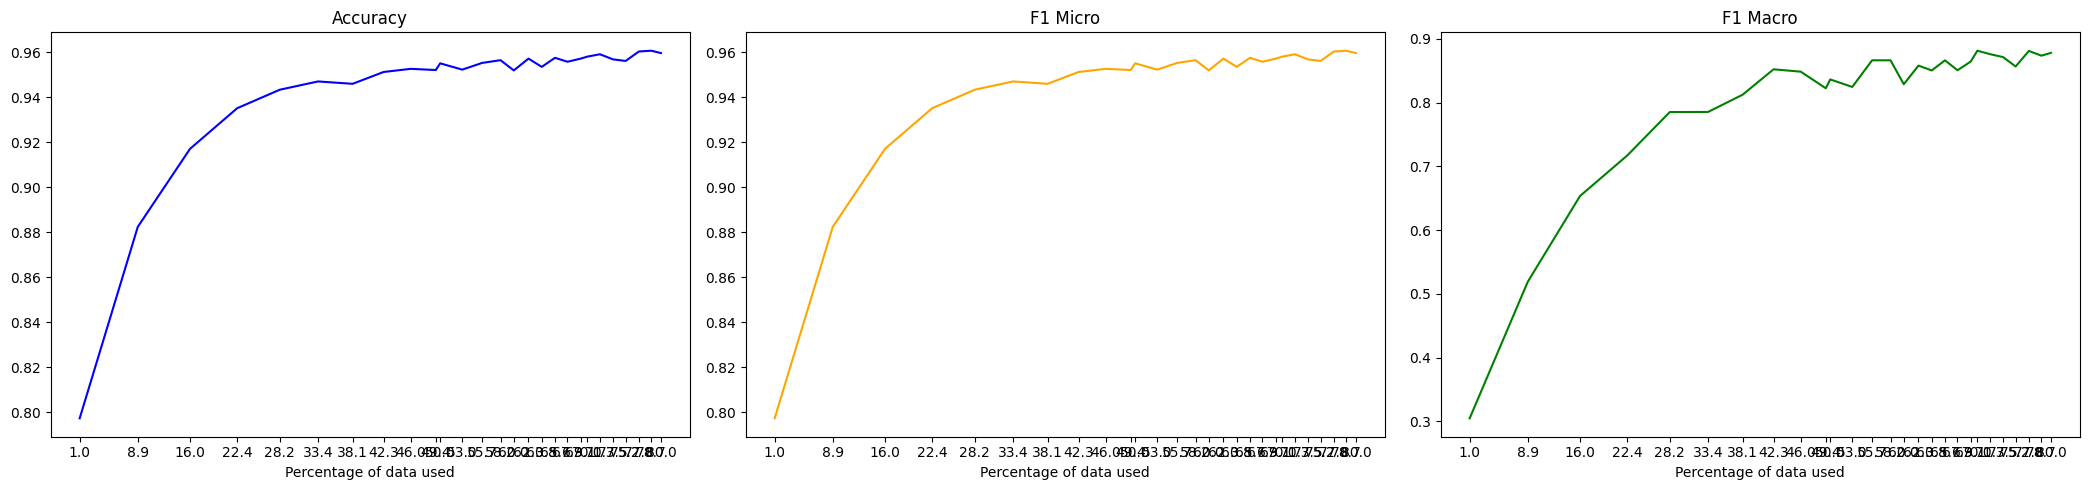

In [21]:
initial_train_size = int(0.01 * total_data)
active_learning(81, 0, 1)

Init Size 10
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6304, Accuracy: 0.8014, F1 Micro: 0.8897, F1 Macro: 0.8853
Epoch 2/10, Train Loss: 0.4839, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Epoch 3/10, Train Loss: 0.4418, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4257, Accuracy: 0.803, F1 Micro: 0.8905, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4169, Accuracy: 0.8304, F1 Micro: 0.9037, F1 Macro: 0.8985
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3785, Accuracy: 0.8505, F1 Micro: 0.9137, F1 Macro: 0.9087
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3439, Accuracy: 0.8767, F1 Micro: 0.9277, F1 Macro: 0.9227
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3093, Accuracy: 0.8839, F1 Micro: 0.9316, F1 Macro: 0.9269
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.274, Accuracy: 0.9042, F1 Micro: 0.9423, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5629, Accuracy: 0.7088, F1 Micro: 0.7088, F1 Macro: 0.4148
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3944, Accuracy: 0.7804, F1 Micro: 0.7804, F1 Macro: 0.7113
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3384, Accuracy: 0.7995, F1 Micro: 0.7995, F1 Macro: 0.7497
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2906, Accuracy: 0.815, F1 Micro: 0.815, F1 Macro: 0.7518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.233, Accuracy: 0.815, F1 Micro: 0.815, F1 Macro: 0.7668
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2122, Accuracy: 0.815, F1 Micro: 0.815, F1 Macro: 0.7615
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1913, Accuracy: 0.8222, F1 Micro: 0.8222, F1 Macro: 0.7497
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1635, Accuracy: 0.8305, F1 Micro: 0.8305, F1 Macro: 0.7737
Epoch 9/10, Train Loss: 0.1457, Accuracy: 0.8103, F1 Micro: 0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5616, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4516, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4254, Accuracy: 0.8198, F1 Micro: 0.8988, F1 Macro: 0.8942
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3767, Accuracy: 0.8667, F1 Micro: 0.922, F1 Macro: 0.9156
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3172, Accuracy: 0.8979, F1 Micro: 0.9391, F1 Macro: 0.9346
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2601, Accuracy: 0.9167, F1 Micro: 0.9498, F1 Macro: 0.9467
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2299, Accuracy: 0.925, F1 Micro: 0.9547, F1 Macro: 0.952
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1884, Accuracy: 0.9344, F1 Micro: 0.9599, F1 Macro: 0.9573
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4544, Accuracy: 0.7634, F1 Micro: 0.7634, F1 Macro: 0.4948
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2938, Accuracy: 0.8137, F1 Micro: 0.8137, F1 Macro: 0.69
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2212, Accuracy: 0.8533, F1 Micro: 0.8533, F1 Macro: 0.7871
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.8576, F1 Micro: 0.8576, F1 Macro: 0.7763
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.8576, F1 Micro: 0.8576, F1 Macro: 0.7745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.864, F1 Micro: 0.864, F1 Macro: 0.7961
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.8715, F1 Micro: 0.8715, F1 Macro: 0.8157
Epoch 8/10, Train Loss: 0.0505, Accuracy: 0.8683, F1 Micro: 0.8683, F1 Macro: 0.798
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.8726, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5355, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4348, Accuracy: 0.8177, F1 Micro: 0.8963, F1 Macro: 0.8881
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3863, Accuracy: 0.8627, F1 Micro: 0.9197, F1 Macro: 0.9137
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3173, Accuracy: 0.9007, F1 Micro: 0.9406, F1 Macro: 0.936
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2484, Accuracy: 0.9241, F1 Micro: 0.9541, F1 Macro: 0.9513
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2097, Accuracy: 0.9339, F1 Micro: 0.9594, F1 Macro: 0.9566
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1881, Accuracy: 0.9337, F1 Micro: 0.9596, F1 Macro: 0.9573
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1597, Accuracy: 0.9384, F1 Micro: 0.9623, F1 Macro: 0.9601
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4464, Accuracy: 0.8053, F1 Micro: 0.8053, F1 Macro: 0.7347
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2767, Accuracy: 0.8532, F1 Micro: 0.8532, F1 Macro: 0.7949
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.185, Accuracy: 0.8532, F1 Micro: 0.8532, F1 Macro: 0.7756
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1531, Accuracy: 0.8767, F1 Micro: 0.8767, F1 Macro: 0.8253
Epoch 5/10, Train Loss: 0.1346, Accuracy: 0.8756, F1 Micro: 0.8756, F1 Macro: 0.8195
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.8787, F1 Micro: 0.8787, F1 Macro: 0.8271
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.8919, F1 Micro: 0.8919, F1 Macro: 0.8538
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.044, Accuracy: 0.8919, F1 Micro: 0.8919, F1 Macro: 0.8521
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.893, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5231, Accuracy: 0.8014, F1 Micro: 0.8897, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4259, Accuracy: 0.8304, F1 Micro: 0.9036, F1 Macro: 0.8983
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3524, Accuracy: 0.8938, F1 Micro: 0.9368, F1 Macro: 0.9323
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2847, Accuracy: 0.916, F1 Micro: 0.9494, F1 Macro: 0.9465
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2284, Accuracy: 0.9326, F1 Micro: 0.959, F1 Macro: 0.9567
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1982, Accuracy: 0.9359, F1 Micro: 0.961, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1656, Accuracy: 0.9436, F1 Micro: 0.9654, F1 Macro: 0.9632
Epoch 8/10, Train Loss: 0.1408, Accuracy: 0.9392, F1 Micro: 0.9628, F1 Macro: 0.9595
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1227, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4204, Accuracy: 0.8159, F1 Micro: 0.8159, F1 Macro: 0.7208
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2323, Accuracy: 0.8573, F1 Micro: 0.8573, F1 Macro: 0.802
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1861, Accuracy: 0.8622, F1 Micro: 0.8622, F1 Macro: 0.8057
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.8789, F1 Micro: 0.8789, F1 Macro: 0.8305
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1044, Accuracy: 0.8829, F1 Micro: 0.8829, F1 Macro: 0.8436
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0811, Accuracy: 0.8878, F1 Micro: 0.8878, F1 Macro: 0.8441
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0786, Accuracy: 0.8898, F1 Micro: 0.8898, F1 Macro: 0.851
Epoch 8/10, Train Loss: 0.0357, Accuracy: 0.8829, F1 Micro: 0.8829, F1 Macro: 0.8351
Epoch 9/10, Train Loss: 0.0351, Accuracy: 0.8848, F1 Micro: 0.8848, F1 Macro: 0.8393
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5119, Accuracy: 0.8019, F1 Micro: 0.8899, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4156, Accuracy: 0.8627, F1 Micro: 0.919, F1 Macro: 0.9103
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3172, Accuracy: 0.9118, F1 Micro: 0.9469, F1 Macro: 0.9433
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2476, Accuracy: 0.9354, F1 Micro: 0.9605, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1932, Accuracy: 0.9446, F1 Micro: 0.966, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1661, Accuracy: 0.9488, F1 Micro: 0.9685, F1 Macro: 0.966
Epoch 7/10, Train Loss: 0.143, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1247, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9696
Epoch 9/10, Train Loss: 0.1035, Accuracy: 0.9538, F1 Micro: 0.9715, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4202, Accuracy: 0.8442, F1 Micro: 0.8442, F1 Macro: 0.8007
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2183, Accuracy: 0.87, F1 Micro: 0.87, F1 Macro: 0.8246
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.166, Accuracy: 0.881, F1 Micro: 0.881, F1 Macro: 0.8382
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1319, Accuracy: 0.8899, F1 Micro: 0.8899, F1 Macro: 0.8493
Epoch 5/10, Train Loss: 0.0893, Accuracy: 0.8829, F1 Micro: 0.8829, F1 Macro: 0.829
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0788, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8605
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0568, Accuracy: 0.8998, F1 Micro: 0.8998, F1 Macro: 0.8629
Epoch 8/10, Train Loss: 0.0694, Accuracy: 0.8899, F1 Micro: 0.8899, F1 Macro: 0.8514
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.872
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5002, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4006, Accuracy: 0.8847, F1 Micro: 0.9315, F1 Macro: 0.9253
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2852, Accuracy: 0.9224, F1 Micro: 0.9531, F1 Macro: 0.95
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2237, Accuracy: 0.9363, F1 Micro: 0.9612, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1857, Accuracy: 0.9469, F1 Micro: 0.9674, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1523, Accuracy: 0.9509, F1 Micro: 0.9697, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1345, Accuracy: 0.9524, F1 Micro: 0.9706, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1101, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4063, Accuracy: 0.85, F1 Micro: 0.85, F1 Macro: 0.7843
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.209, Accuracy: 0.8751, F1 Micro: 0.8751, F1 Macro: 0.8332
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1685, Accuracy: 0.8819, F1 Micro: 0.8819, F1 Macro: 0.8335
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1132, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8702
Epoch 5/10, Train Loss: 0.0913, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8624
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0627, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8766
Epoch 7/10, Train Loss: 0.0571, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8739
Epoch 8/10, Train Loss: 0.0445, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8704
Epoch 9/10, Train Loss: 0.022, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8719
Epoch 10/10, Train Loss: 0.0261, Accuracy: 0.9022, F1 Micro: 0.9022, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4956, Accuracy: 0.8116, F1 Micro: 0.8924, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3724, Accuracy: 0.8967, F1 Micro: 0.9385, F1 Macro: 0.9341
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2694, Accuracy: 0.9309, F1 Micro: 0.958, F1 Macro: 0.9549
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.213, Accuracy: 0.9368, F1 Micro: 0.9615, F1 Macro: 0.9592
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1693, Accuracy: 0.9441, F1 Micro: 0.9658, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1423, Accuracy: 0.9498, F1 Micro: 0.9691, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1238, Accuracy: 0.95, F1 Micro: 0.9693, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1078, Accuracy: 0.954, F1 Micro: 0.9716, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3779, Accuracy: 0.8454, F1 Micro: 0.8454, F1 Macro: 0.786
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2495, Accuracy: 0.8652, F1 Micro: 0.8652, F1 Macro: 0.819
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1838, Accuracy: 0.8926, F1 Micro: 0.8926, F1 Macro: 0.857
Epoch 4/10, Train Loss: 0.1281, Accuracy: 0.8916, F1 Micro: 0.8916, F1 Macro: 0.857
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0962, Accuracy: 0.8963, F1 Micro: 0.8963, F1 Macro: 0.8599
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0651, Accuracy: 0.9001, F1 Micro: 0.9001, F1 Macro: 0.8664
Epoch 7/10, Train Loss: 0.0537, Accuracy: 0.8775, F1 Micro: 0.8775, F1 Macro: 0.848
Epoch 8/10, Train Loss: 0.0414, Accuracy: 0.8963, F1 Micro: 0.8963, F1 Macro: 0.8617
Epoch 9/10, Train Loss: 0.0363, Accuracy: 0.8897, F1 Micro: 0.8897, F1 Macro: 0.8523
Epoch 10/10, Train Loss: 0.0247, Accuracy: 0.8944, F1 Micro: 0.8944, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4975, Accuracy: 0.8076, F1 Micro: 0.8927, F1 Macro: 0.8881
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3623, Accuracy: 0.899, F1 Micro: 0.9399, F1 Macro: 0.936
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2579, Accuracy: 0.9332, F1 Micro: 0.9593, F1 Macro: 0.9567
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2006, Accuracy: 0.9448, F1 Micro: 0.9661, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1649, Accuracy: 0.9502, F1 Micro: 0.9694, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1368, Accuracy: 0.954, F1 Micro: 0.9716, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.122, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.9706
Epoch 8/10, Train Loss: 0.0962, Accuracy: 0.954, F1 Micro: 0.9715, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0842, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3606, Accuracy: 0.8257, F1 Micro: 0.8257, F1 Macro: 0.7358
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2381, Accuracy: 0.8742, F1 Micro: 0.8742, F1 Macro: 0.8311
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1742, Accuracy: 0.8975, F1 Micro: 0.8975, F1 Macro: 0.8695
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1272, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8808
Epoch 5/10, Train Loss: 0.087, Accuracy: 0.9012, F1 Micro: 0.9012, F1 Macro: 0.8704
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0552, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8791
Epoch 7/10, Train Loss: 0.0445, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8742
Epoch 8/10, Train Loss: 0.0281, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8755
Epoch 9/10, Train Loss: 0.0217, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8758
Epoch 10/10, Train Loss: 0.0162, Accuracy: 0.8938, F1 Micro: 0.8938, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4922, Accuracy: 0.8241, F1 Micro: 0.9002, F1 Macro: 0.8942
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3547, Accuracy: 0.9057, F1 Micro: 0.9436, F1 Macro: 0.9397
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2434, Accuracy: 0.9354, F1 Micro: 0.9606, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1945, Accuracy: 0.9484, F1 Micro: 0.9683, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.161, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1314, Accuracy: 0.9538, F1 Micro: 0.9715, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1128, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0932, Accuracy: 0.9583, F1 Micro: 0.9743, F1 Macro: 0.9721
Epoch 9/10, Train Loss: 0.0866, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3973, Accuracy: 0.8527, F1 Micro: 0.8527, F1 Macro: 0.7996
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2418, Accuracy: 0.8791, F1 Micro: 0.8791, F1 Macro: 0.8397
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1544, Accuracy: 0.9037, F1 Micro: 0.9037, F1 Macro: 0.8732
Epoch 4/10, Train Loss: 0.1143, Accuracy: 0.8933, F1 Micro: 0.8933, F1 Macro: 0.858
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0723, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8802
Epoch 6/10, Train Loss: 0.0625, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.869
Epoch 7/10, Train Loss: 0.0366, Accuracy: 0.8999, F1 Micro: 0.8999, F1 Macro: 0.8653
Epoch 8/10, Train Loss: 0.0333, Accuracy: 0.8848, F1 Micro: 0.8848, F1 Macro: 0.8425
Epoch 9/10, Train Loss: 0.0328, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8754
Epoch 10/10, Train Loss: 0.0218, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8757

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4886, Accuracy: 0.8057, F1 Micro: 0.8918, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.357, Accuracy: 0.903, F1 Micro: 0.942, F1 Macro: 0.9383
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2455, Accuracy: 0.937, F1 Micro: 0.9615, F1 Macro: 0.9593
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1914, Accuracy: 0.9444, F1 Micro: 0.9659, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.16, Accuracy: 0.9503, F1 Micro: 0.9695, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1339, Accuracy: 0.9556, F1 Micro: 0.9725, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1145, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0978, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9719
Epoch 9/10, Train Loss: 0.0831, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3473, Accuracy: 0.8194, F1 Micro: 0.8194, F1 Macro: 0.7211
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2093, Accuracy: 0.8655, F1 Micro: 0.8655, F1 Macro: 0.8158
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1768, Accuracy: 0.889, F1 Micro: 0.889, F1 Macro: 0.8521
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1047, Accuracy: 0.9022, F1 Micro: 0.9022, F1 Macro: 0.8745
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0768, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8793
Epoch 6/10, Train Loss: 0.0572, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.8751
Epoch 7/10, Train Loss: 0.0415, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8749
Epoch 8/10, Train Loss: 0.0356, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8766
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0299, Accuracy: 0.9078, F1 Micro: 0.9078, F1 Macro: 0.8812
Epoch 10/10, Train Loss: 0.0234, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4856, Accuracy: 0.8247, F1 Micro: 0.8996, F1 Macro: 0.8907
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3358, Accuracy: 0.9042, F1 Micro: 0.9428, F1 Macro: 0.9392
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2377, Accuracy: 0.9392, F1 Micro: 0.9629, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1883, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1523, Accuracy: 0.954, F1 Micro: 0.9717, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1288, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1084, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9733
Epoch 8/10, Train Loss: 0.0929, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0823, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.371, Accuracy: 0.8454, F1 Micro: 0.8454, F1 Macro: 0.8104
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1989, Accuracy: 0.8697, F1 Micro: 0.8697, F1 Macro: 0.8151
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1422, Accuracy: 0.8932, F1 Micro: 0.8932, F1 Macro: 0.8539
Epoch 4/10, Train Loss: 0.1171, Accuracy: 0.8922, F1 Micro: 0.8922, F1 Macro: 0.8524
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0679, Accuracy: 0.8932, F1 Micro: 0.8932, F1 Macro: 0.8629
Epoch 6/10, Train Loss: 0.0616, Accuracy: 0.8913, F1 Micro: 0.8913, F1 Macro: 0.8497
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0543, Accuracy: 0.9044, F1 Micro: 0.9044, F1 Macro: 0.8726
Epoch 8/10, Train Loss: 0.0428, Accuracy: 0.9016, F1 Micro: 0.9016, F1 Macro: 0.869
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0243, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8754
Epoch 10/10, Train Loss: 0.0166, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4859, Accuracy: 0.8227, F1 Micro: 0.8995, F1 Macro: 0.8936
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3329, Accuracy: 0.9172, F1 Micro: 0.9498, F1 Macro: 0.9464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2338, Accuracy: 0.9415, F1 Micro: 0.9642, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1812, Accuracy: 0.9481, F1 Micro: 0.9681, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1501, Accuracy: 0.954, F1 Micro: 0.9716, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1269, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.107, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9734
Epoch 8/10, Train Loss: 0.0871, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0761, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.389, Accuracy: 0.8577, F1 Micro: 0.8577, F1 Macro: 0.8016
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.225, Accuracy: 0.8709, F1 Micro: 0.8709, F1 Macro: 0.82
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1485, Accuracy: 0.8916, F1 Micro: 0.8916, F1 Macro: 0.8518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1266, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0826, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8866
Epoch 6/10, Train Loss: 0.064, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0496, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.893
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8821
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.8952
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4775, Accuracy: 0.8349, F1 Micro: 0.905, F1 Macro: 0.8971
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3157, Accuracy: 0.916, F1 Micro: 0.949, F1 Macro: 0.9433
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2257, Accuracy: 0.9363, F1 Micro: 0.9613, F1 Macro: 0.9592
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.183, Accuracy: 0.9484, F1 Micro: 0.9684, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1491, Accuracy: 0.9514, F1 Micro: 0.9701, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1256, Accuracy: 0.9535, F1 Micro: 0.9713, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1035, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0882, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9734
Epoch 9/10, Train Loss: 0.0772, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3738, Accuracy: 0.8643, F1 Micro: 0.8643, F1 Macro: 0.8156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2125, Accuracy: 0.8935, F1 Micro: 0.8935, F1 Macro: 0.8612
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1559, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.8855
Epoch 4/10, Train Loss: 0.0999, Accuracy: 0.9123, F1 Micro: 0.9123, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0775, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8909
Epoch 6/10, Train Loss: 0.0649, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8871
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0466, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.894
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0291, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.8976
Epoch 9/10, Train Loss: 0.0239, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.8925
Epoch 10/10, Train Loss: 0.0228, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4784, Accuracy: 0.8365, F1 Micro: 0.9068, F1 Macro: 0.9015
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3126, Accuracy: 0.9236, F1 Micro: 0.9537, F1 Macro: 0.9509
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2268, Accuracy: 0.9418, F1 Micro: 0.9645, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1677, Accuracy: 0.946, F1 Micro: 0.967, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.953, F1 Micro: 0.9711, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1164, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1021, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9743
Epoch 8/10, Train Loss: 0.0869, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.9725
Epoch 9/10, Train Loss: 0.0723, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3582, Accuracy: 0.8502, F1 Micro: 0.8502, F1 Macro: 0.7943
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2079, Accuracy: 0.8895, F1 Micro: 0.8895, F1 Macro: 0.8529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1521, Accuracy: 0.8959, F1 Micro: 0.8959, F1 Macro: 0.8675
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0964, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.8783
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0758, Accuracy: 0.9078, F1 Micro: 0.9078, F1 Macro: 0.8812
Epoch 6/10, Train Loss: 0.0633, Accuracy: 0.9014, F1 Micro: 0.9014, F1 Macro: 0.8758
Epoch 7/10, Train Loss: 0.045, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8782
Epoch 8/10, Train Loss: 0.0325, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8814
Epoch 9/10, Train Loss: 0.028, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8777
Epoch 10/10, Train Loss: 0.0171, Accuracy: 0.905, F1 Micro: 0.905, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.475, Accuracy: 0.8545, F1 Micro: 0.9146, F1 Macro: 0.9049
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3084, Accuracy: 0.9193, F1 Micro: 0.9513, F1 Macro: 0.9482
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2119, Accuracy: 0.9425, F1 Micro: 0.9648, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1731, Accuracy: 0.9503, F1 Micro: 0.9696, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1466, Accuracy: 0.955, F1 Micro: 0.9723, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1176, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.096, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0836, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9738
Epoch 9/10, Train Loss: 0.0685, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3601, Accuracy: 0.8612, F1 Micro: 0.8612, F1 Macro: 0.8111
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2244, Accuracy: 0.8955, F1 Micro: 0.8955, F1 Macro: 0.8614
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1627, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.883
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1053, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.8872
Epoch 5/10, Train Loss: 0.0815, Accuracy: 0.9047, F1 Micro: 0.9047, F1 Macro: 0.8793
Epoch 6/10, Train Loss: 0.06, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8801
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0438, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.8875
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0401, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.888
Epoch 9/10, Train Loss: 0.0206, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8802
Epoch 10/10, Train Loss: 0.0239, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4725, Accuracy: 0.8484, F1 Micro: 0.9123, F1 Macro: 0.9062
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3101, Accuracy: 0.9214, F1 Micro: 0.9528, F1 Macro: 0.9499
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2165, Accuracy: 0.9488, F1 Micro: 0.9686, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1718, Accuracy: 0.9514, F1 Micro: 0.9702, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.141, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.114, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9746
Epoch 7/10, Train Loss: 0.0988, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9739
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9741
Epoch 9/10, Train Loss: 0.0704, Accuracy: 0.9615, F1 Micro: 0.976, F1 Macro: 0.9736
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3766, Accuracy: 0.8566, F1 Micro: 0.8566, F1 Macro: 0.8114
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2525, Accuracy: 0.8941, F1 Micro: 0.8941, F1 Macro: 0.8649
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1749, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8741
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1162, Accuracy: 0.9041, F1 Micro: 0.9041, F1 Macro: 0.8765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1009, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8809
Epoch 6/10, Train Loss: 0.0848, Accuracy: 0.8932, F1 Micro: 0.8932, F1 Macro: 0.8677
Epoch 7/10, Train Loss: 0.0752, Accuracy: 0.9041, F1 Micro: 0.9041, F1 Macro: 0.8745
Epoch 8/10, Train Loss: 0.0452, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8729
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.8995, F1 Micro: 0.8995, F1 Macro: 0.8687
Epoch 10/10, Train Loss: 0.0579, Accuracy: 0.9014, F1 Micro: 0.9014, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4747, Accuracy: 0.8613, F1 Micro: 0.9188, F1 Macro: 0.9118
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2999, Accuracy: 0.9311, F1 Micro: 0.9581, F1 Macro: 0.9554
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2098, Accuracy: 0.9467, F1 Micro: 0.9673, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9523, F1 Micro: 0.9707, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1368, Accuracy: 0.9583, F1 Micro: 0.9743, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1114, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9746
Epoch 7/10, Train Loss: 0.0935, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0791, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0664, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3516, Accuracy: 0.8667, F1 Micro: 0.8667, F1 Macro: 0.822
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2144, Accuracy: 0.8984, F1 Micro: 0.8984, F1 Macro: 0.8675
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1381, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.8936
Epoch 4/10, Train Loss: 0.1054, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8735
Epoch 5/10, Train Loss: 0.0913, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8845
Epoch 6/10, Train Loss: 0.0559, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8869
Epoch 7/10, Train Loss: 0.0459, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.8895
Epoch 8/10, Train Loss: 0.038, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.8893
Epoch 9/10, Train Loss: 0.0197, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.8843
Epoch 10/10, Train Loss: 0.0221, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.8873

Sentiment analysis accuracy: 0.9171, F1 Micro: 0.91

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.461, Accuracy: 0.8675, F1 Micro: 0.9216, F1 Macro: 0.9134
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2889, Accuracy: 0.9365, F1 Micro: 0.9612, F1 Macro: 0.9586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2064, Accuracy: 0.9472, F1 Micro: 0.9677, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9542, F1 Micro: 0.9718, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1343, Accuracy: 0.9583, F1 Micro: 0.9743, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.111, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9754
Epoch 7/10, Train Loss: 0.0918, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0776, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9756
Epoch 9/10, Train Loss: 0.0664, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3321, Accuracy: 0.8701, F1 Micro: 0.8701, F1 Macro: 0.8258
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2054, Accuracy: 0.8859, F1 Micro: 0.8859, F1 Macro: 0.8435
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1406, Accuracy: 0.9007, F1 Micro: 0.9007, F1 Macro: 0.8711
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1133, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8839
Epoch 5/10, Train Loss: 0.0879, Accuracy: 0.9007, F1 Micro: 0.9007, F1 Macro: 0.8726
Epoch 6/10, Train Loss: 0.0689, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8744
Epoch 7/10, Train Loss: 0.0497, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.8782
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0412, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8858
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8813
Epoch 10/10, Train Loss: 0.0413, Accuracy: 0.9017, F1 Micro: 0.9017, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4658, Accuracy: 0.8717, F1 Micro: 0.9242, F1 Macro: 0.9159
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2896, Accuracy: 0.9366, F1 Micro: 0.9613, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.204, Accuracy: 0.9479, F1 Micro: 0.9682, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.9566, F1 Micro: 0.9732, F1 Macro: 0.971
Epoch 5/10, Train Loss: 0.1301, Accuracy: 0.9566, F1 Micro: 0.973, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1097, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.974
Epoch 7/10, Train Loss: 0.0901, Accuracy: 0.9613, F1 Micro: 0.9761, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0773, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9754
Epoch 9/10, Train Loss: 0.0656, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9743
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3471, Accuracy: 0.8586, F1 Micro: 0.8586, F1 Macro: 0.7995
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2015, Accuracy: 0.8969, F1 Micro: 0.8969, F1 Macro: 0.8646
Epoch 3/10, Train Loss: 0.1302, Accuracy: 0.885, F1 Micro: 0.885, F1 Macro: 0.8416
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1063, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0829, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.8822
Epoch 6/10, Train Loss: 0.0609, Accuracy: 0.9078, F1 Micro: 0.9078, F1 Macro: 0.8835
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0396, Accuracy: 0.9215, F1 Micro: 0.9215, F1 Macro: 0.8973
Epoch 8/10, Train Loss: 0.0285, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8875
Epoch 9/10, Train Loss: 0.0279, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8806
Epoch 10/10, Train Loss: 0.0301, Accuracy: 0.9142, F1 Micro: 0.9142, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4637, Accuracy: 0.8667, F1 Micro: 0.9213, F1 Macro: 0.912
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2909, Accuracy: 0.9337, F1 Micro: 0.9594, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.204, Accuracy: 0.9497, F1 Micro: 0.9691, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.163, Accuracy: 0.9531, F1 Micro: 0.9711, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1279, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9738
Epoch 6/10, Train Loss: 0.1149, Accuracy: 0.9604, F1 Micro: 0.9756, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.089, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0761, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.0651, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3578, Accuracy: 0.8551, F1 Micro: 0.8551, F1 Macro: 0.8052
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2272, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8704
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1441, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8783
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1024, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8785
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0754, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.076, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.8902
Epoch 7/10, Train Loss: 0.0482, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8798
Epoch 8/10, Train Loss: 0.0331, Accuracy: 0.9016, F1 Micro: 0.9016, F1 Macro: 0.8711
Epoch 9/10, Train Loss: 0.0322, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.879
Epoch 10/10, Train Loss: 0.0221, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4621, Accuracy: 0.8745, F1 Micro: 0.9261, F1 Macro: 0.9196
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.282, Accuracy: 0.9344, F1 Micro: 0.9602, F1 Macro: 0.9579
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1962, Accuracy: 0.949, F1 Micro: 0.9687, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1625, Accuracy: 0.9533, F1 Micro: 0.9713, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.131, Accuracy: 0.9583, F1 Micro: 0.9743, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1088, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0898, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0774, Accuracy: 0.9649, F1 Micro: 0.9781, F1 Macro: 0.9758
Epoch 9/10, Train Loss: 0.0651, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3422, Accuracy: 0.824, F1 Micro: 0.824, F1 Macro: 0.7995
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2075, Accuracy: 0.8836, F1 Micro: 0.8836, F1 Macro: 0.8557
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1499, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8706
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0952, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8743
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0883, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.878
Epoch 6/10, Train Loss: 0.0598, Accuracy: 0.8898, F1 Micro: 0.8898, F1 Macro: 0.8547
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0518, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8795
Epoch 8/10, Train Loss: 0.0329, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8735
Epoch 9/10, Train Loss: 0.0364, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.8718
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4611, Accuracy: 0.8797, F1 Micro: 0.9289, F1 Macro: 0.9227
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2824, Accuracy: 0.9351, F1 Micro: 0.9605, F1 Macro: 0.958
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1975, Accuracy: 0.9462, F1 Micro: 0.967, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1614, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1326, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1083, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9754
Epoch 7/10, Train Loss: 0.0862, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9738
Epoch 8/10, Train Loss: 0.0769, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0631, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3446, Accuracy: 0.8722, F1 Micro: 0.8722, F1 Macro: 0.8331
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2186, Accuracy: 0.8961, F1 Micro: 0.8961, F1 Macro: 0.8688
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1409, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8814
Epoch 4/10, Train Loss: 0.0945, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0755, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8861
Epoch 6/10, Train Loss: 0.0695, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0461, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0373, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8859
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0386, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.8859
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4536, Accuracy: 0.8792, F1 Micro: 0.9283, F1 Macro: 0.9212
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2713, Accuracy: 0.9359, F1 Micro: 0.9608, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1925, Accuracy: 0.954, F1 Micro: 0.9716, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1552, Accuracy: 0.9554, F1 Micro: 0.9726, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1021, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0874, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.976
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0621, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3362, Accuracy: 0.8714, F1 Micro: 0.8714, F1 Macro: 0.8349
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2174, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.8763
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1427, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8898
Epoch 4/10, Train Loss: 0.104, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0719, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.891
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.051, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.891
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0422, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.894
Epoch 8/10, Train Loss: 0.033, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.887
Epoch 9/10, Train Loss: 0.0329, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.8934
Epoch 10/10, Train Loss: 0.0281, Accuracy: 0.911

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4513, Accuracy: 0.8747, F1 Micro: 0.926, F1 Macro: 0.9195
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2691, Accuracy: 0.9378, F1 Micro: 0.9621, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1876, Accuracy: 0.9476, F1 Micro: 0.9679, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1484, Accuracy: 0.9585, F1 Micro: 0.9744, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1215, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0997, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9757
Epoch 7/10, Train Loss: 0.087, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9756
Epoch 8/10, Train Loss: 0.0703, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0597, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3391, Accuracy: 0.8639, F1 Micro: 0.8639, F1 Macro: 0.8253
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1958, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.872
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1375, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8788
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0927, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8804
Epoch 5/10, Train Loss: 0.0634, Accuracy: 0.9047, F1 Micro: 0.9047, F1 Macro: 0.8791
Epoch 6/10, Train Loss: 0.0614, Accuracy: 0.8975, F1 Micro: 0.8975, F1 Macro: 0.8682
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0345, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.878
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0391, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8871
Epoch 9/10, Train Loss: 0.0121, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8788
Epoch 10/10, Train Loss: 0.0168, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4487, Accuracy: 0.8887, F1 Micro: 0.9339, F1 Macro: 0.929
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2633, Accuracy: 0.9368, F1 Micro: 0.9615, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1792, Accuracy: 0.9531, F1 Micro: 0.9712, F1 Macro: 0.9695
Epoch 4/10, Train Loss: 0.1451, Accuracy: 0.9528, F1 Micro: 0.9711, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.9637, F1 Micro: 0.9774, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0837, Accuracy: 0.9658, F1 Micro: 0.9788, F1 Macro: 0.9769
Epoch 8/10, Train Loss: 0.0696, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0576, Accuracy: 0.9663, F1 Micro: 0.9791, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3446, Accuracy: 0.8488, F1 Micro: 0.8488, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1983, Accuracy: 0.9044, F1 Micro: 0.9044, F1 Macro: 0.8771
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1273, Accuracy: 0.9044, F1 Micro: 0.9044, F1 Macro: 0.8743
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0902, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8802
Epoch 5/10, Train Loss: 0.0637, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8758
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0456, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.8918
Epoch 7/10, Train Loss: 0.0365, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8844
Epoch 8/10, Train Loss: 0.0396, Accuracy: 0.9162, F1 Micro: 0.9162, F1 Macro: 0.8905
Epoch 9/10, Train Loss: 0.0304, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0205, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4434, Accuracy: 0.8898, F1 Micro: 0.9343, F1 Macro: 0.9287
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2575, Accuracy: 0.9375, F1 Micro: 0.9618, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1873, Accuracy: 0.9526, F1 Micro: 0.9708, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1464, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1192, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0978, Accuracy: 0.9655, F1 Micro: 0.9786, F1 Macro: 0.9764
Epoch 7/10, Train Loss: 0.0817, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9748
Epoch 8/10, Train Loss: 0.0691, Accuracy: 0.9609, F1 Micro: 0.9757, F1 Macro: 0.9734
Epoch 9/10, Train Loss: 0.0569, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9755
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3352, Accuracy: 0.8653, F1 Micro: 0.8653, F1 Macro: 0.8182
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1954, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8762
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1479, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8892
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0969, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.8943
Epoch 5/10, Train Loss: 0.0808, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8901
Epoch 6/10, Train Loss: 0.0637, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.8932
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0444, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.8986
Epoch 8/10, Train Loss: 0.0422, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8863
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8893
Epoch 10/10, Train Loss: 0.0275, Accuracy: 0.9216, F1 Micro: 0.9216, F

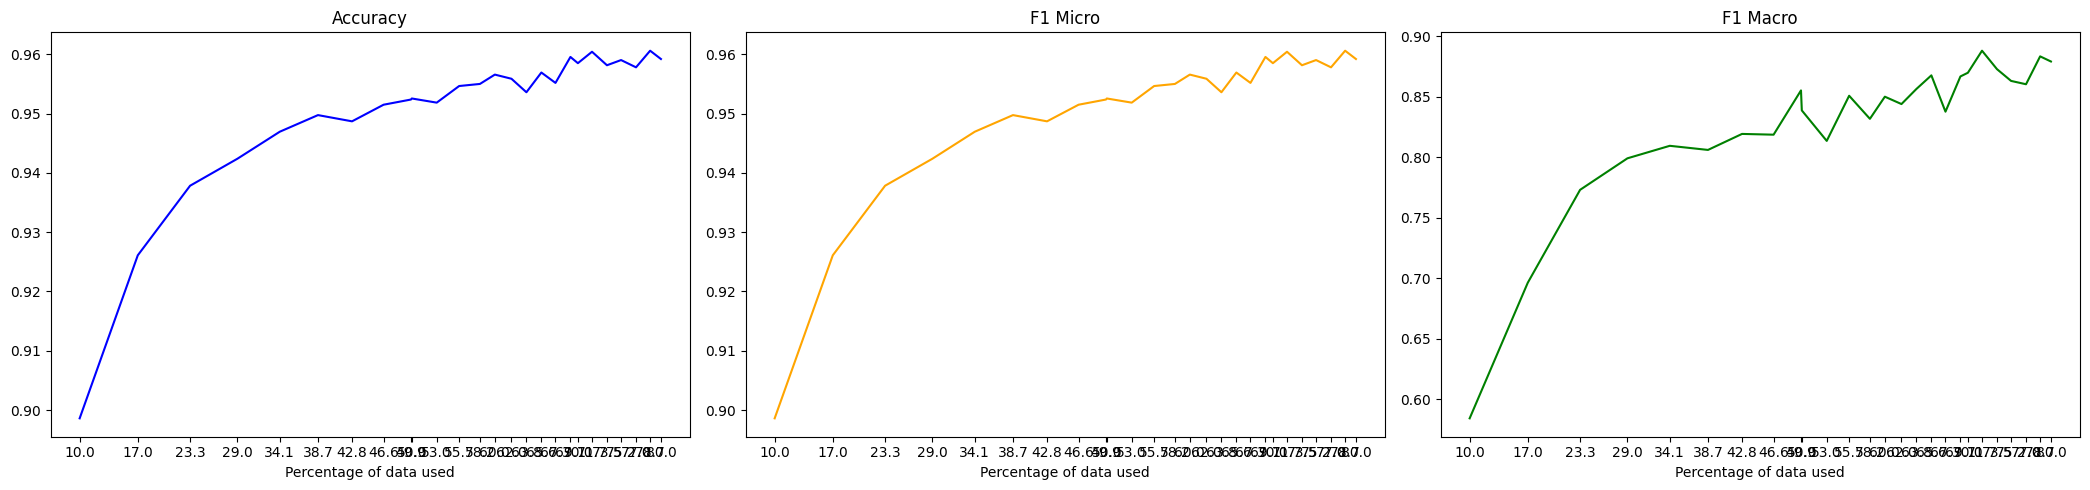

In [22]:
initial_train_size = int(0.1 * total_data)
active_learning(81, 0, 10)